<a href="https://colab.research.google.com/github/tnewtont/ModCloth_Recommendation_System/blob/main/rsp_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import sqlite3
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [2]:
# Making the utility matrix
def make_um(df):
    um = df.pivot_table(index = 'user_id', columns = 'item_id', values = 'rating')
    um.fillna(0, inplace = True)
    return um

In [3]:
def recommend_items(UM, user_LC, CS, model, kay):
    rec_items = np.zeros((len(UM.index), kay))

    user_dict = {}
    for u in range(len(user_LC.index)):
        user_dict[u] = user_LC.index[u]
    user_dict = dict((v,k) for k,v in user_dict.items())

    for user in user_LC.index:
        user_reshaped = np.array(user_LC.loc[user]).reshape((1,len(user_LC.loc[user])))
        items = model.kneighbors(user_reshaped, return_distance = False)
        rec_items[user_dict[user],:] = np.array(CS.columns)[items]

    rec_items_df = pd.DataFrame(rec_items, index = user_dict.keys())
    return rec_items_df

In [4]:
def obtain_all_user_recs(user_df, rec_model_df, generic_rec):

    # Obtain a series that contains the avg product rating from each user in the test dataset
    # By grouping, we can then automatically extract the unique user ID's
    grouped = user_df.groupby('user_id')['rating'].mean()

    # Store a list of each specific user
    user_list = grouped.index


    PI_mean_adj_dict = dict(zip(generic_rec.index, generic_rec['weighted_vals'])) # Item to weight
    PI_mean_adj_dict2 = dict((v,k) for k,v in PI_mean_adj_dict.items()) # Weight to item

    all_user_recs = {}

    for user in user_list:
        # Extract avg product rating from a specific user
        specific_user_mean = grouped[user]
        # Extract items already reviewed by user
        specific_user_actual_items = user_df.loc[user_df['user_id'] == user, 'item_id']

        # If a specific user's avg product rating is >= 4, use collaborative filtering
        # Otherwise, if a specified user's avg product rating is < 4 give generic recommendations instead

        if specific_user_mean >= 4:
                # Extract the products recommended by the model
                items_pred = rec_model_df.loc[user]

                # Exclude products already purchased by the user
                final_items = list(set(items_pred) - set(specific_user_actual_items).intersection(set(items_pred)))
                final_items2 = [PI_mean_adj_dict[f] for f in final_items]
                final_items2.sort(reverse = True) # We want the weights from greatest to least, so reverse = True
                final_items3 = [PI_mean_adj_dict2[f] for f in final_items2][0:3]
                all_user_recs[user] = final_items3
        else:
                _generic_rec = set(generic_rec.index[0:5])
                final_generic_recs = list(_generic_rec - set(specific_user_actual_items).intersection(_generic_rec))[0:3]
                all_user_recs[user] = final_generic_recs
    return all_user_recs

In [5]:
def convert_recs_dict_to_df(users_recs_dict):
    df = pd.DataFrame(users_recs_dict.items(), columns = ['username', 'items_recommended'])
    df2 = pd.concat([df['username'], pd.DataFrame(df['items_recommended'].to_list()).add_prefix('product')], axis = 1)
    df2 = df2.rename(columns = {'product0': 'product_1', 'product1': 'product_2', 'product2': 'product_3'})
    return df2

In [6]:
# Makes the model using SVD
def build_model_SVD(um, n, kay, p_val):
    R = um.values
    R_mean = np.mean(R, axis = 1)
    R_mean = R_mean.reshape(-1,1)
    R_demeaned = R - R_mean

    U, sigma, Vt = svds(R_demeaned, k = n) # This gets applied to the *demeaned* ratings matrix
    sigma = np.diag(sigma)

    R_red = U@sigma@Vt
    R_red = R_red + R_mean # Un-demean the ratings matrix

    um_red = pd.DataFrame(R_red, columns = um.columns, index = um.index)
    cs_red = um_red.corr(method = 'spearman')

    nn_red = NearestNeighbors(n_neighbors = kay, p = p_val)
    nn_red.fit(cs_red)

    return nn_red

In [7]:
# Load filtered dataframe
df = pd.read_csv('/content/df_modcloth_filtered.csv')
df

,item_id,user_id,rating,category
0,7443,Alex,4,Dresses
1,7443,carolyn.agan,3,Dresses
2,7443,Robyn,4,Dresses
3,7443,De,4,Dresses
4,7443,tasha,4,Dresses
...,...,...,...,...
93910,154797,BernMarie,5,Dresses
93911,77949,Sam,4,Bottoms
93912,67194,Janice,5,Dresses
93913,71607,amy,3,Outerwear


In [8]:
# Load dataframe containing generic recommendations
pop = pd.read_csv('/content/pop_items.csv')
pop.set_index('item_id', inplace = True)
pop

,mean,num_reviews,cat,weighted_vals
item_id,,,,
34935,4.482247,1887,Tops,9.303801e+06
21296,4.171760,1636,Bottoms,5.460000e+06
32405,4.325829,1599,Dresses,6.917001e+06
32406,4.328648,1494,Dresses,6.467001e+06
32403,4.367199,1378,Dresses,6.018001e+06
...,...,...,...,...
153801,4.083333,24,Bottoms,6.860005e+04
138414,4.000000,24,Tops,6.720080e+04
153397,3.791667,24,Bottoms,1.371119e-01


Create 3 dictionaries to map out item_id to weighted values, average ratings, and categories.

In [9]:
item_to_weighted_vals = dict(zip(pop.index, pop['weighted_vals']))

In [10]:
item_to_mean_rating = dict(zip(pop.index, pop['mean']))

In [105]:
item_to_cat = dict(zip(pop.index, pop['cat']))

In [11]:
# Use make_um to create the utility matrix
um = make_um(df)
um

item_id,6454,7443,11960,16411,21296,22563,24853,27439,27590,28252,...,154505,154540,154543,154567,154661,154665,154794,154797,155293,155317
user_id,,,,,,,,,,,,,,,,,,,,,
"""Ferrari"")",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#1dad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Chelle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Tree',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zurajohnson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuzu_zoom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
🇦🇺,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since the ratings are ordinal/rank-based, we will use Spearman's correlation.

In [12]:
cs = um.corr(method = 'spearman')
cs

item_id,6454,7443,11960,16411,21296,22563,24853,27439,27590,28252,...,154505,154540,154543,154567,154661,154665,154794,154797,155293,155317
item_id,,,,,,,,,,,,,,,,,,,,,
6454,1.000000,0.068324,0.053686,0.039297,0.048203,0.039648,0.049449,0.061552,0.037637,0.040417,...,0.036821,0.019727,-0.000972,0.091684,0.061388,0.035897,0.046448,0.033179,0.100182,0.089478
7443,0.068324,1.000000,0.114484,0.112813,0.120469,0.102194,0.095090,0.086744,0.100983,0.106817,...,0.034368,0.027694,0.026820,0.028728,0.027750,0.033541,0.026664,0.039383,0.047621,0.052852
11960,0.053686,0.114484,1.000000,0.113169,0.108872,0.117086,0.116585,0.093671,0.088930,0.106381,...,0.033073,0.019365,0.029695,0.057957,0.042516,0.052956,0.016499,0.029208,0.047048,0.036908
16411,0.039297,0.112813,0.113169,1.000000,0.123298,0.095751,0.088756,0.098161,0.087320,0.089824,...,0.025691,0.014570,0.034105,0.037542,0.038708,0.033576,0.017944,0.034430,0.023444,0.028778
21296,0.048203,0.120469,0.108872,0.123298,1.000000,0.102865,0.104940,0.094092,0.106626,0.114525,...,0.025251,0.019916,0.028853,0.032007,0.028967,0.032007,0.009642,0.035231,0.043449,0.035802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154665,0.035897,0.033541,0.052956,0.033576,0.032007,0.041016,0.042434,0.055937,0.040290,0.051249,...,0.068886,0.050126,0.028265,0.067266,0.101110,1.000000,0.057316,0.062338,0.048699,0.073074
154794,0.046448,0.026664,0.016499,0.017944,0.009642,0.015646,0.016232,0.003680,0.016026,0.004859,...,0.028962,0.031861,-0.000622,0.028268,0.064432,0.057316,1.000000,0.053074,0.030922,0.022759
154797,0.033179,0.039383,0.029208,0.034430,0.035231,0.032642,0.038279,0.015623,0.010041,0.024459,...,0.042212,0.070115,0.026100,0.041222,0.022738,0.062338,0.053074,1.000000,0.068144,0.050468


We then calculate the linear combinations by utilizing matrix multiplication for each user that we will then use for our model to evaluate.

In [13]:
user_LC = um@cs
user_LC

item_id,6454,7443,11960,16411,21296,22563,24853,27439,27590,28252,...,154505,154540,154543,154567,154661,154665,154794,154797,155293,155317
user_id,,,,,,,,,,,,,,,,,,,,,
"""Ferrari"")",0.523910,0.660719,0.680375,0.527445,0.556202,0.637333,0.573613,0.596824,0.584918,0.592128,...,0.206865,0.192513,0.190472,0.287193,0.507716,0.594803,0.308654,0.246852,0.222885,0.343305
#,0.257196,0.469893,0.580747,0.502325,0.562046,0.495646,0.487415,0.441805,0.443010,0.528802,...,0.130669,0.147500,0.173448,0.199775,0.118633,0.202114,0.076976,0.277215,0.250661,0.215905
#1dad,0.081977,0.329556,0.233603,0.218380,0.208539,0.236790,0.246058,0.179568,0.244533,0.304895,...,0.049156,0.055773,0.065799,0.163360,0.120738,0.221442,-0.007833,0.043055,0.180251,-0.012253
'Chelle,0.180786,0.205820,0.219967,0.168732,0.223808,0.160789,0.208197,0.134193,0.138987,0.271256,...,0.087793,0.097335,0.113008,0.131992,0.149911,0.038773,0.112918,0.121311,0.144919,0.295192
'Tree',0.579958,0.552420,0.823034,0.629798,0.620359,0.759280,0.614793,0.606357,0.489773,0.675222,...,0.329849,0.165081,0.114989,0.271390,0.178396,0.364062,0.248744,0.433012,0.400893,0.312069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zurajohnson,0.594719,1.204901,1.332723,1.120946,1.102677,1.215751,1.057991,1.141124,1.119589,1.256869,...,0.372017,0.312016,0.494757,0.464318,0.264436,0.645407,0.350011,0.416707,0.707983,0.643968
zuzu_zoom,0.203460,0.254603,0.278410,0.218151,0.276479,0.230031,0.253305,0.208595,0.240862,0.262624,...,0.091326,0.139021,0.204057,0.121933,0.176589,0.188611,0.118634,0.235188,0.279690,0.230834
🇦🇺,0.292026,0.289367,0.319362,0.252313,0.282708,0.238571,0.301009,0.264456,0.212086,0.252274,...,0.303305,0.130404,0.070579,0.420195,0.203092,0.360832,0.308647,0.221147,0.394678,0.241177


We want to make sure that our model's scope is wide enough to capture similar products. We build a k Nearest Neighbors model where the number of neighors, n, is 10.<br>
In our pre-modeling, we concluded that using 300 singular values yields the best model.

In [14]:
nn_300 = build_model_SVD(um, 300, 10, 2)

The dataframe below contains 10 recommendations for each user.

In [15]:
recommended_items = recommend_items(um, user_LC, cs, nn_300, 10)
recommended_items

,0,1,2,3,4,5,6,7,8,9
"""Ferrari"")",44893.0,28967.0,153592.0,144318.0,153524.0,154794.0,128359.0,54887.0,153988.0,80238.0
#,59176.0,28967.0,67022.0,153599.0,54887.0,153676.0,49587.0,154794.0,135264.0,153374.0
#1dad,126098.0,70538.0,154794.0,40899.0,153599.0,107539.0,145391.0,153676.0,153881.0,28967.0
'Chelle,141880.0,153676.0,143049.0,145391.0,28967.0,153599.0,154216.0,143422.0,153867.0,154794.0
'Tree',107794.0,84931.0,153524.0,28967.0,67507.0,153599.0,151796.0,154216.0,145391.0,152592.0
...,...,...,...,...,...,...,...,...,...,...
zurajohnson,114610.0,89042.0,106758.0,121272.0,105593.0,28967.0,106348.0,153599.0,153524.0,152066.0
zuzu_zoom,126114.0,28967.0,153599.0,153676.0,154794.0,144318.0,16411.0,145334.0,145391.0,153374.0
🇦🇺,153599.0,144572.0,143422.0,86074.0,154794.0,145391.0,32403.0,145215.0,153524.0,28967.0
🐻,151870.0,153599.0,154353.0,154124.0,153676.0,143422.0,145215.0,154794.0,145391.0,153607.0


This is the same dataframe as above but mapped to the average ratings instead.

In [44]:
# Items with their corresponding average ratings
rec_items_ratings = recommended_items.replace(item_to_mean_rating)
rec_items_ratings

,0,1,2,3,4,5,6,7,8,9
"""Ferrari"")",3.681275,4.502982,3.596491,3.794872,3.846154,4.370370,3.832090,3.828185,4.675676,4.273514
#,4.512326,4.502982,4.787946,3.566667,3.828185,4.153846,3.994498,4.370370,4.566667,4.138889
#1dad,3.900585,4.469856,4.370370,4.521421,3.566667,4.194872,4.100000,4.153846,4.506579,4.502982
'Chelle,4.613095,4.153846,4.533333,4.100000,4.502982,3.566667,3.675000,3.666667,3.032258,4.370370
'Tree',4.288961,3.979003,3.846154,4.502982,3.963154,3.566667,4.387097,3.675000,4.100000,4.120000
...,...,...,...,...,...,...,...,...,...,...
zurajohnson,4.198413,3.501182,4.545246,4.378378,4.219895,4.502982,4.000000,3.566667,3.846154,3.098039
zuzu_zoom,4.280967,4.502982,3.566667,4.153846,4.370370,3.794872,3.668254,4.541667,4.100000,4.138889
🇦🇺,3.566667,4.741379,3.666667,3.905660,4.370370,4.100000,4.367199,4.060606,3.846154,4.502982
🐻,3.666667,3.566667,3.724138,3.078431,4.153846,3.666667,4.060606,4.370370,4.100000,2.303030


In [45]:
# Items with their corresponding weighted values
rec_items_weights = recommended_items.replace(item_to_weighted_vals)
rec_items_weights

,0,1,2,3,4,5,6,7,8,9
"""Ferrari"")",2.182411e+00,5.436001e+06,1.108234e+00,2.900370e-01,2.102759e-01,1.180003e+05,1.738709e+00,2.016590,2.249010e+05,3.557701e+06
#,5.052001e+06,5.436001e+06,3.003001e+06,4.235935e-01,2.016590e+00,1.296006e+05,3.695384e+00,118000.279233,1.644005e+05,1.192009e+05
#1dad,1.063121e+00,5.138101e+06,1.180003e+05,5.192400e+06,4.235935e-01,3.272001e+06,9.840056e+04,129600.613879,8.220002e+05,5.436001e+06
'Chelle,1.007501e+06,1.296006e+05,1.632009e+05,9.840056e+04,5.436001e+06,4.235935e-01,7.434708e-01,0.900653,1.027212e+00,1.180003e+05
'Tree',1.188900e+06,2.230336e+00,2.102759e-01,5.436001e+06,5.808175e+00,4.235935e-01,1.360007e+05,0.743471,9.840056e+04,8.240044e+04
...,...,...,...,...,...,...,...,...,...,...
zurajohnson,1.269600e+06,2.267298e+00,4.761600e+06,6.480005e+05,1.450800e+06,5.436001e+06,1.484004e+05,0.423593,2.102759e-01,6.209141e-01
zuzu_zoom,1.275300e+06,5.436001e+06,4.235935e-01,1.296006e+05,1.180003e+05,2.900370e-01,4.985634e+00,130800.199589,9.840056e+04,1.192009e+05
🇦🇺,4.235935e-01,3.850000e+05,9.006528e-01,6.812777e-01,1.180003e+05,9.840056e+04,6.018001e+06,93800.186529,2.102759e-01,5.436001e+06
🐻,7.526631e-01,4.235935e-01,5.079791e-01,1.135377e+00,1.296006e+05,9.006528e-01,9.380019e+04,118000.279233,9.840056e+04,1.005010e+00


In [18]:
all_user_recs_dict = obtain_all_user_recs(df, recommended_items, pop)
all_user_recs_dict

{'"Ferrari")': [28967, 80238, 153988],
 '#': [28967, 67022, 135264],
 '#1dad': [28967, 40899, 70538],
 "'Chelle": [28967, 143049, 153676],
 "'Tree'": [28967, 151796, 145391],
 '(usually)': [21296, 32403, 32405],
 '-L': [143049, 153676, 150782],
 '.': [153550, 144759, 151796],
 '..': [131290, 144759, 150782],
 '01085': [152047, 143049, 145391],
 '0123annac': [21296, 32403, 32405],
 '02ambersmith': [21296, 32403, 32405],
 '02draper': [28967, 70538, 107539],
 '0311': [21296, 32403, 32405],
 '044de0c8': [28967, 105593, 153598],
 '0846': [32403, 28967, 132261],
 '0bazooka0': [28967, 106758, 67022],
 '0heatherstone0': [105593, 143049, 153676],
 '0k4sh1m0m0': [28967, 114610, 153676],
 '10097685jk': [21296, 32403, 32405],
 '100daysofrain': [28967, 70538, 69157],
 '10227sk1': [32403, 105593, 121272],
 '12.basch.09': [28967, 114610, 153676],
 '1234babysitter': [32403, 28967, 106348],
 '123jane123': [21296, 32403, 32405],
 '12sarahyoung': [32403, 28967, 69157],
 '13brokenroses': [114610, 152546, 

In [107]:
# Store our result as its own dataframe
all_users_recs_df = convert_recs_dict_to_df(all_user_recs_dict)
all_users_recs_df

,username,product_1,product_2,product_3
0,"""Ferrari"")",28967.0,80238.0,153988.0
1,#,28967.0,67022.0,135264.0
2,#1dad,28967.0,40899.0,70538.0
3,'Chelle,28967.0,143049.0,153676.0
4,'Tree',28967.0,151796.0,145391.0
...,...,...,...,...
43465,zurajohnson,21296.0,32403.0,32405.0
43466,zuzu_zoom,28967.0,145334.0,153676.0
43467,🇦🇺,21296.0,32403.0,32405.0
43468,🐻,153676.0,154794.0,145391.0


In [108]:
# Map each item to its category and store it in its own column
all_users_recs_df['cat_1'] = all_users_recs_df['product_1'].replace(item_to_cat)
all_users_recs_df['cat_2'] = all_users_recs_df['product_2'].replace(item_to_cat)
all_users_recs_df['cat_3'] = all_users_recs_df['product_3'].replace(item_to_cat)

In [109]:
all_users_recs_df

,username,product_1,product_2,product_3,cat_1,cat_2,cat_3
0,"""Ferrari"")",28967.0,80238.0,153988.0,Dresses,Bottoms,Tops
1,#,28967.0,67022.0,135264.0,Dresses,Tops,Bottoms
2,#1dad,28967.0,40899.0,70538.0,Dresses,Tops,Dresses
3,'Chelle,28967.0,143049.0,153676.0,Dresses,Outerwear,Tops
4,'Tree',28967.0,151796.0,145391.0,Dresses,Bottoms,Tops
...,...,...,...,...,...,...,...
43465,zurajohnson,21296.0,32403.0,32405.0,Bottoms,Dresses,Dresses
43466,zuzu_zoom,28967.0,145334.0,153676.0,Dresses,Dresses,Tops
43467,🇦🇺,21296.0,32403.0,32405.0,Bottoms,Dresses,Dresses
43468,🐻,153676.0,154794.0,145391.0,Tops,Dresses,Tops


In [47]:
# Checking how many times each product was recommended
all_users_recs_df['product_1'].value_counts()

,count
product_1,
28967.0,18884
32403.0,9311
21296.0,9237
34935.0,2009
153988.0,527
...,...
58940.0,1
153737.0,1
59176.0,1


In [75]:
prod_1_top_10 = all_users_recs_df['product_1'].value_counts().head(10).index.tolist()
prod_1_top_10 = [str(p) for p in prod_1_top_10]
prod_1_top_10_counts = all_users_recs_df['product_1'].value_counts().head(10).values.tolist()

Text(0.5, 1.0, 'Top 10 First Products Recommended')

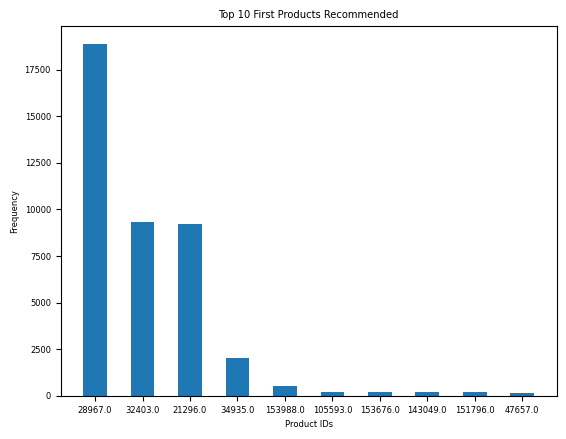

In [97]:
plt.bar(prod_1_top_10, prod_1_top_10_counts, width = 0.5)
plt.rcParams['font.size'] = 6
plt.xlabel('Product IDs')
plt.ylabel('Frequency')
plt.title('Top 10 First Products Recommended')


In [48]:
all_users_recs_df['product_2'].value_counts()

,count
product_2,
28967.0,9392
32403.0,9245
105593.0,3048
70538.0,2936
67022.0,2542
...,...
68332.0,1
103764.0,1
148245.0,1


In [99]:
prod_2_top_10 = all_users_recs_df['product_2'].value_counts().head(10).index.tolist()
prod_2_top_10 = [str(p) for p in prod_2_top_10]
prod_2_top_10_counts = all_users_recs_df['product_2'].value_counts().head(10).values.tolist()

Text(0.5, 1.0, 'Top 10 Second Products Recommended')

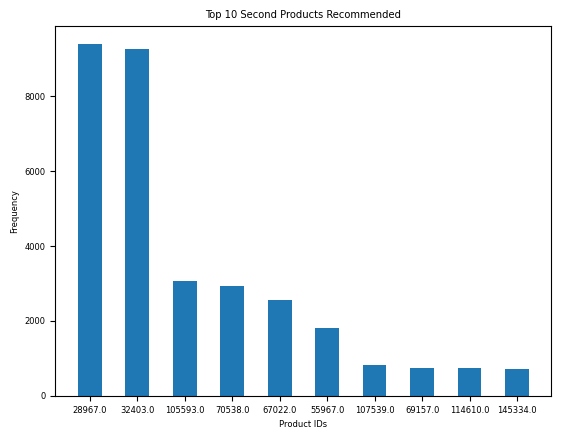

In [100]:
plt.bar(prod_2_top_10, prod_2_top_10_counts, width = 0.5)
plt.rcParams['font.size'] = 6
plt.xlabel('Product IDs')
plt.ylabel('Frequency')
plt.title('Top 10 Second Products Recommended')

In [49]:
all_users_recs_df['product_3'].value_counts()

,count
product_3,
32405.0,8439
105593.0,6414
153676.0,3160
70538.0,1968
153988.0,1602
...,...
78227.0,1
78573.0,1
64921.0,1


In [101]:
prod_3_top_10 = all_users_recs_df['product_3'].value_counts().head(10).index.tolist()
prod_3_top_10 = [str(p) for p in prod_3_top_10]
prod_3_top_10_counts = all_users_recs_df['product_3'].value_counts().head(10).values.tolist()

Text(0.5, 1.0, 'Top 10 Third Products Recommended')

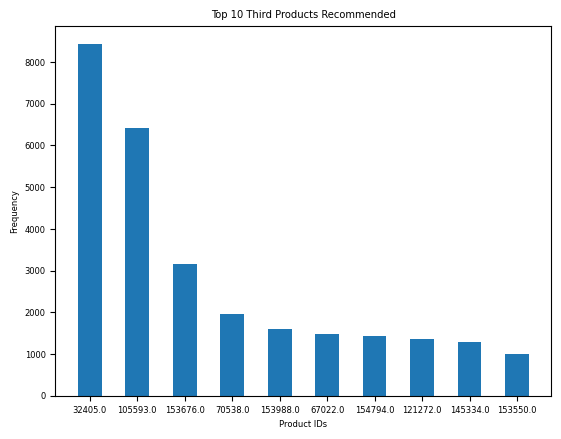

In [102]:
plt.bar(prod_3_top_10, prod_3_top_10_counts, width = 0.5)
plt.rcParams['font.size'] = 6
plt.xlabel('Product IDs')
plt.ylabel('Frequency')
plt.title('Top 10 Third Products Recommended')

In [112]:
# We will also store our result as a SQL database
conn = sqlite3.connect('user_recommendations.sqlite')
all_users_recs_df.to_sql('recommendations', conn, if_exists = 'replace', index = False)

43470

In [113]:
pd.read_sql('SELECT * FROM recommendations', conn)

,username,product_1,product_2,product_3,cat_1,cat_2,cat_3
0,"""Ferrari"")",28967.0,80238.0,153988.0,Dresses,Bottoms,Tops
1,#,28967.0,67022.0,135264.0,Dresses,Tops,Bottoms
2,#1dad,28967.0,40899.0,70538.0,Dresses,Tops,Dresses
3,'Chelle,28967.0,143049.0,153676.0,Dresses,Outerwear,Tops
4,'Tree',28967.0,151796.0,145391.0,Dresses,Bottoms,Tops
...,...,...,...,...,...,...,...
43465,zurajohnson,21296.0,32403.0,32405.0,Bottoms,Dresses,Dresses
43466,zuzu_zoom,28967.0,145334.0,153676.0,Dresses,Dresses,Tops
43467,🇦🇺,21296.0,32403.0,32405.0,Bottoms,Dresses,Dresses
43468,🐻,153676.0,154794.0,145391.0,Tops,Dresses,Tops
